In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
df = pd.read_csv("HAM10000_metadata.csv")
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

<Axes: xlabel='dx', ylabel='count'>

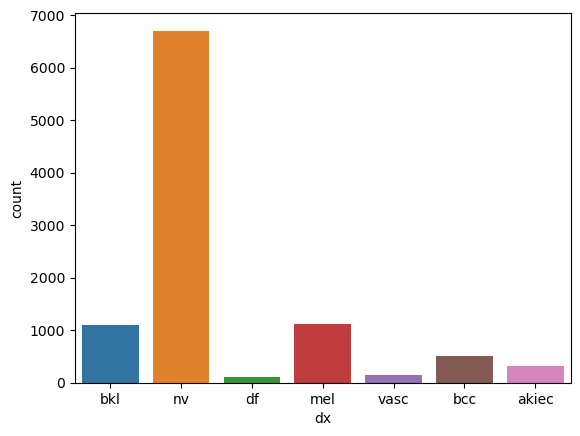

In [5]:
sns.countplot(df, x="dx")

In [6]:
from pathlib import Path
data_path = Path("data")
train_dir = data_path / "train"
test_dir = data_path / "test"
train_dir, test_dir

(WindowsPath('data/train'), WindowsPath('data/test'))

In [7]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

In [30]:
alexnet_transforms = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )
])

In [31]:
dataset = datasets.ImageFolder(train_dir, transform=alexnet_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=alexnet_transforms)

In [32]:
train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=0.25)
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

In [33]:
class_names = train_dataset.dataset.classes
class_names

['Actinic keratoses and intraepithelial carcinomae',
 'basal cell carcinoma',
 'benign keratosis-like lesions',
 'dermatofibroma',
 'melanocytic nevi',
 'melanoma',
 'pyogenic granulomas and hemorrhage']

In [34]:
BATCH_SIZE = 128
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)
train_dataloader, val_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x24fe46271f0>,
 <torch.utils.data.dataloader.DataLoader at 0x24fe4626da0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'melanocytic nevi')

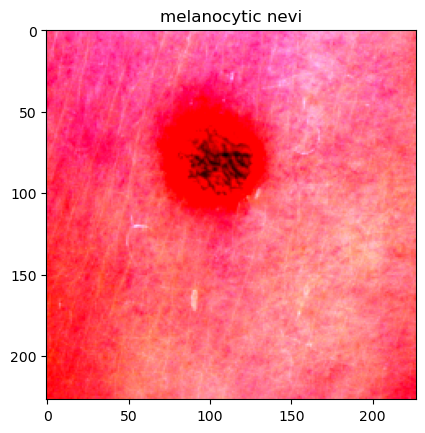

In [35]:
image, label = next(iter(train_dataloader))
plt.imshow(image[0].permute(1,2,0))
plt.title(class_names[label[0]])

In [13]:
class VGG16_NET(nn.Module):
    def __init__(self):
        super(VGG16_NET, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc14 = nn.Linear(25088, 4096)
        self.fc15 = nn.Linear(4096, 4096)
        self.fc16 = nn.Linear(4096, 7)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.maxpool(x)
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = self.maxpool(x)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc14(x))
        x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc15(x))
        x = F.dropout(x, 0.5)
        x = self.fc16(x)
        return x

In [13]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [14]:
def trainModel(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               optimizer: torch.optim.Optimizer, 
               loss_fn = torch.nn.Module, 
               device: torch.device = device):
    model.train()
    train_loss, train_acc = 0, 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_score(y.cpu(), y_pred.cpu().argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f}")

In [15]:
def valMmodel(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
    val_loss, val_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            val_loss += loss_fn(y_pred, y)
            val_acc += accuracy_score(y.cpu(), y_pred.cpu().argmax(dim=1))
        val_loss /= len(dataloader)
        val_acc /= len(dataloader)
        print(f"Val loss: {val_loss:.4f} | Val accuracy: {val_acc:.4f}")
        return val_loss

In [16]:
def evalModel(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module,
               device: torch.device = device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_score(y.cpu(), y_pred.cpu().argmax(dim=1)) 
        loss /= len(dataloader)
        acc /= len(dataloader)       
    return {"model_name": model.__class__.__name__, 
            "model_loss": loss.item(),
            "model_acc": acc}

In [18]:
model = VGG16_NET().to(device=device)
model

VGG16_NET(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv13): Conv2d(512, 512, kernel_size=(3,

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
torch.cuda.empty_cache()

In [20]:
torch.manual_seed(0)
EPOCHS = 10
early_stopping = EarlyStopping(patience=5, verbose=False, delta=0.001)
for epoch in tqdm(range(EPOCHS)):
    trainModel(model, train_dataloader, optimizer, loss_fn, device)
    val_loss = valMmodel(model, val_dataloader, loss_fn, device)
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        break

  0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 0.0264 | Train accuracy: 0.5865
Val loss: 1.1459 | Val accuracy: 0.6743
Train loss: 0.0184 | Train accuracy: 0.6724
Val loss: 1.1335 | Val accuracy: 0.6743
Train loss: 0.0292 | Train accuracy: 0.6669
Val loss: 1.1228 | Val accuracy: 0.6743
Train loss: 0.0176 | Train accuracy: 0.6696
Val loss: 0.9591 | Val accuracy: 0.6743
Train loss: 0.0205 | Train accuracy: 0.6709
Val loss: 0.9387 | Val accuracy: 0.6743
Train loss: 0.0216 | Train accuracy: 0.6635
Val loss: 0.9061 | Val accuracy: 0.6738
Train loss: 0.0249 | Train accuracy: 0.6693
Val loss: 0.9047 | Val accuracy: 0.6694
Train loss: 0.0142 | Train accuracy: 0.6747
Val loss: 0.8814 | Val accuracy: 0.6677
Train loss: 0.0206 | Train accuracy: 0.6769
Val loss: 1.0081 | Val accuracy: 0.6696
EarlyStopping counter: 1 out of 5
Train loss: 0.0098 | Train accuracy: 0.6828
Val loss: 0.8468 | Val accuracy: 0.7143


In [22]:
model_results = evalModel(model, test_dataloader, loss_fn, device)
print(model_results)

{'model_name': 'VGG16_NET', 'model_loss': 1.370302438735962, 'model_acc': 0.4241431451612903}


In [23]:
torch.save(model.state_dict(), f"models/{model_results['model_name']}.pth")

In [26]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [27]:
model = AlexNet(7).to(device=device)
model

AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  

In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.005, weight_decay=0.005)

In [36]:
torch.manual_seed(0)
EPOCHS = 10
early_stopping = EarlyStopping(patience=5, verbose=False, delta=0.001)
for epoch in tqdm(range(EPOCHS)):
    torch.cuda.empty_cache()
    trainModel(model, train_dataloader, optimizer, loss_fn, device)
    val_loss = valMmodel(model, val_dataloader, loss_fn, device)
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        break

  0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 0.0138 | Train accuracy: 0.6017
Val loss: 1.9958 | Val accuracy: 0.6622
Train loss: 0.0138 | Train accuracy: 0.6594
Val loss: 0.9485 | Val accuracy: 0.6622
Train loss: 0.0100 | Train accuracy: 0.6315
Val loss: 1.1777 | Val accuracy: 0.6038
EarlyStopping counter: 1 out of 5
Train loss: 0.0126 | Train accuracy: 0.6447
Val loss: 2.3481 | Val accuracy: 0.6622
EarlyStopping counter: 2 out of 5
Train loss: 0.1898 | Train accuracy: 0.5993
Val loss: 3.1699 | Val accuracy: 0.6622
EarlyStopping counter: 3 out of 5
Train loss: 1.1494 | Train accuracy: 0.6038
Val loss: 65.0738 | Val accuracy: 0.6439
EarlyStopping counter: 4 out of 5
Train loss: 0.0274 | Train accuracy: 0.6112
Val loss: 60.8831 | Val accuracy: 0.6622
EarlyStopping counter: 5 out of 5


In [37]:
model_results = evalModel(model, test_dataloader, loss_fn, device)
print(model_results)

{'model_name': 'AlexNet', 'model_loss': 29.54945182800293, 'model_acc': 0.6549479166666666}


In [38]:
torch.save(model.state_dict(), f"models/{model_results['model_name']}.pth")